# Loading and Splitting Dataset

## Loading Dataset

In [1]:
from datasets import load_dataset

op_dataset_raw = load_dataset("csv" , data_files=r"D:\Virtual Environments\Thesis\datasets\OpSpam dataset.csv")
op_dataset_raw = op_dataset_raw["train"].remove_columns(['hotel' , 'source'])

## Preprocessing op dataset

In [2]:
def combine_labels(record):
    record["label"] = record["deceptive"] + "_" + record["polarity"]
    return record
op_dataset_raw = op_dataset_raw.map(combine_labels)
op_dataset_raw = op_dataset_raw.remove_columns(["deceptive" , "polarity"])

unique_classes = list(set(op_dataset_raw["label"]))
unique_classes.sort(reverse=True)
print(unique_classes)

def one_hot_encoding(record):
    record["label"] = unique_classes.index(record["label"])
    return record

op_dataset_raw = op_dataset_raw.map(one_hot_encoding)


['truthful_positive', 'truthful_negative', 'deceptive_positive', 'deceptive_negative']


In [3]:
op_dataset_raw[0]

{'text': 'We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n',
 'label': 0}

## Data Visualization

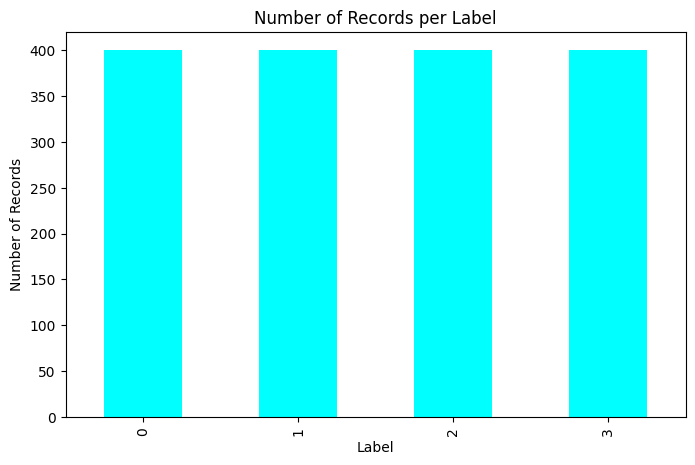

In [3]:
import matplotlib.pyplot as plt

# Convert the dataset to a pandas DataFrame
df1 = op_dataset_raw.to_pandas()

# Use pandas value_counts to count the labels
label_counts = df1['label'].value_counts().sort_index()

label_counts.plot(kind='bar', figsize=(8, 5), color='cyan')
plt.xlabel('Label')
plt.ylabel('Number of Records')
plt.title('Number of Records per Label')
plt.show()


## Splitting Dataset

In [4]:
from datasets import DatasetDict, Dataset

split_dataset_op = op_dataset_raw.train_test_split(test_size=0.1 , seed=42)
train_test_split_op = split_dataset_op["train"].train_test_split(test_size=0.1111 , seed=42)
op_dataset = DatasetDict({
    "train" : train_test_split_op["train"],
    "test" : train_test_split_op["test"],
    "validation" : split_dataset_op["test"]
})


In [13]:
op_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1280
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 160
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 160
    })
})

# Tokenization

## Tokenization Function

In [5]:
from transformers import AutoTokenizer, DataCollatorWithPadding

# tokenizer also passed to ensure used tokenizer is of same checkpoint as the model
# Dynamic Padding. Hence, dp
def tokenize(example , tokenizer):
    return tokenizer(example["text"], truncation=True)


## Tokenization

### Electra

In [9]:
electra_checkpoint = 'google/electra-base-discriminator'
electra_tokenizer = AutoTokenizer.from_pretrained(electra_checkpoint)
tokenized_dataset_dp_electra_op = op_dataset.map(tokenize, batched=True, fn_kwargs={'tokenizer': electra_tokenizer})

### BERT

In [10]:
bert_checkpoint = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_checkpoint)
tokenized_dataset_dp_bert_op = op_dataset.map(tokenize , batched = True , fn_kwargs = {'tokenizer' : bert_tokenizer})

###  DistilBERT

In [11]:
distilbert_checkpoint = "distilbert/distilbert-base-uncased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_checkpoint)
tokenized_dataset_dp_distilbert_op = op_dataset.map(tokenize, batched=True , fn_kwargs= {'tokenizer' : distilbert_tokenizer})

### RoBERTa

In [12]:
roberta_checkpoint = "FacebookAI/roberta-base"
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_checkpoint)
tokenized_dataset_dp_roberta_op = op_dataset.map(tokenize, batched=True , fn_kwargs= {'tokenizer' : roberta_tokenizer})

# Evaluate Function

In [13]:
import evaluate
import numpy as np

def compute_metrics(evaluation_predictions):
  logits , actual_labels = evaluation_predictions
  accuracy_metric = evaluate.load("accuracy")
  f1_metric = evaluate.load("f1")
  precision_metric = evaluate.load("precision")
  recall_metric = evaluate.load("recall")

  predicted_labels = np.argmax(logits , axis = -1)
  accuracy = accuracy_metric.compute(predictions=predicted_labels , references=actual_labels)
  f1 = f1_metric.compute(predictions=predicted_labels , references=actual_labels, average='macro')
  precision = precision_metric.compute(predictions=predicted_labels , references=actual_labels , average='macro')
  recall = recall_metric.compute(predictions=predicted_labels , references=actual_labels, average='macro')

  return {**accuracy , **f1 , **precision , **recall}

# Training

## Electra

In [19]:
import torch
torch.cuda.empty_cache()

In [36]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer , Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(electra_checkpoint , num_labels=4)
data_collator = DataCollatorWithPadding(tokenizer=electra_tokenizer)

output_directory = './models/Electra'

training_args = TrainingArguments(
    output_dir = output_directory,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate = 0.00002,
    weight_decay=0.01,
    eval_strategy = 'epoch',
    report_to = []
    )

trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_dataset_dp_electra_op['train'],
    eval_dataset = tokenized_dataset_dp_electra_op['validation'],
    data_collator = data_collator,
    processing_class = electra_tokenizer,
    compute_metrics = compute_metrics
)

trainer.train()
trainer.save_model(output_directory)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.686313,0.787500,0.776525,0.810812,0.778551
2,No log,0.455159,0.825000,0.812820,0.846578,0.811080
3,No log,0.313603,0.893750,0.892086,0.891376,0.894744
4,No log,0.457251,0.837500,0.821222,0.871429,0.817187
5,No log,0.355101,0.875000,0.867921,0.875199,0.865341


## BERT

In [34]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer , Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(bert_checkpoint , num_labels=4)
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

output_directory = './models/BERT'

training_args = TrainingArguments(
    output_dir = output_directory,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate = 0.00002,
    weight_decay=0.01,
    eval_strategy = 'epoch',
    report_to = []
    )

trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_dataset_dp_bert_op['train'],
    eval_dataset = tokenized_dataset_dp_bert_op['validation'],
    data_collator = data_collator,
    processing_class = bert_tokenizer,
    compute_metrics = compute_metrics
)

trainer.train()
trainer.save_model(output_directory)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.508655,0.837500,0.825383,0.829786,0.824290
2,No log,0.321941,0.881250,0.878673,0.880753,0.883807
3,No log,0.302181,0.881250,0.876130,0.876809,0.875852
4,No log,0.332754,0.887500,0.881540,0.885020,0.880966
5,No log,0.328577,0.881250,0.875523,0.877727,0.874290


## DistilBERT

In [33]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer , Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(distilbert_checkpoint, num_labels=4)
data_collator = DataCollatorWithPadding(tokenizer=distilbert_tokenizer)

output_directory = './models/DistilBERT'

training_args = TrainingArguments(
    output_dir = output_directory,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate = 0.00002,
    weight_decay=0.01,
    eval_strategy = 'epoch',
    report_to = []
    )

trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_dataset_dp_distilbert_op['train'],
    eval_dataset = tokenized_dataset_dp_distilbert_op['validation'],
    data_collator = data_collator,
    processing_class = distilbert_tokenizer,
    compute_metrics = compute_metrics
)

trainer.train()
trainer.save_model(output_directory)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.575929,0.856250,0.846187,0.852819,0.844034
2,No log,0.355498,0.887500,0.883422,0.884182,0.885227
3,No log,0.300006,0.900000,0.897029,0.896316,0.899858
4,No log,0.283626,0.900000,0.893974,0.902034,0.890767
5,No log,0.270121,0.906250,0.900761,0.903667,0.899148


## RoBERTa

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer , Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(roberta_checkpoint , num_labels=4)
data_collator = DataCollatorWithPadding(tokenizer=roberta_tokenizer)

output_directory = './models/RoBERTa'

training_args = TrainingArguments(
    output_dir = output_directory,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate = 0.00002,
    weight_decay=0.01,
    eval_strategy = 'epoch',
    report_to = [],
    )

trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_dataset_dp_roberta_op['train'],
    eval_dataset = tokenized_dataset_dp_roberta_op['validation'],
    data_collator = data_collator,
    processing_class = roberta_tokenizer,
    compute_metrics = compute_metrics
)
trainer.train()
trainer.save_model(output_directory)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\Virtual Environments\Thesis\env\Lib\site-packages\transformers\training_args.py:1590: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.310002,0.893750,0.887148,0.892503,0.886364
2,No log,0.274751,0.900000,0.897684,0.904654,0.906960
3,No log,0.225616,0.943750,0.941194,0.941540,0.941335
4,No log,0.284670,0.937500,0.933540,0.944171,0.928693
5,No log,0.256241,0.937500,0.934250,0.935417,0.933523


# Base Learner Predictions

## Loading Models

In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

electra = AutoModelForSequenceClassification.from_pretrained('./models/Electra')
electra_tokenizer = AutoTokenizer.from_pretrained('./models/Electra')

bert = AutoModelForSequenceClassification.from_pretrained('./models/BERT')
bert_tokenizer = AutoTokenizer.from_pretrained('./models/Electra')

distilbert = AutoModelForSequenceClassification.from_pretrained('./models/DistilBERT')
distilbert_tokenizer = AutoTokenizer.from_pretrained('./models/Electra')

## Getting Predictions

In [41]:
from transformers import Trainer, TrainingArguments
from datasets import concatenate_datasets

training_args = TrainingArguments(
    output_dir = './predictions',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
)

electra_trainer = Trainer(
    electra,
    training_args,
    processing_class = electra_tokenizer
)

bert_trainer = Trainer(
    bert,
    training_args,
    processing_class = bert_tokenizer
)

distilbert_trainer = Trainer(
    distilbert,
    training_args,
    processing_class = distilbert_tokenizer
)

tokenized_dataset_dp_electra_op_combined = concatenate_datasets([tokenized_dataset_dp_electra_op['test'] , tokenized_dataset_dp_electra_op['validation']])
tokenized_dataset_dp_bert_op_combined = concatenate_datasets([tokenized_dataset_dp_bert_op['test'] , tokenized_dataset_dp_bert_op['validation']])
tokenized_dataset_dp_distilbert_op_combined = concatenate_datasets([tokenized_dataset_dp_distilbert_op['test'] , tokenized_dataset_dp_distilbert_op['validation']])


electra_outputs = electra_trainer.predict(tokenized_dataset_dp_electra_op_combined)
bert_outputs = bert_trainer.predict(tokenized_dataset_dp_bert_op_combined)
distilbert_outputs = distilbert_trainer.predict(tokenized_dataset_dp_distilbert_op_combined)

In [15]:
electra_outputs.predictions

array([[-0.66308486, -1.43721   ,  3.0861626 , -0.8970183 ],
       [-0.7137503 , -1.4687352 ,  3.080502  , -0.89906025],
       [ 3.1207328 , -0.94269246, -0.48463607, -1.6172389 ],
       [ 3.106535  , -0.8019607 , -0.6701002 , -1.5754206 ],
       [-0.01979489,  2.5679324 , -1.5783356 , -0.8314981 ],
       [-0.36806595, -1.531097  ,  3.0728288 , -1.1968529 ],
       [ 3.0462546 , -1.017493  , -0.3505312 , -1.6441224 ],
       [ 3.0673099 , -0.9944266 , -0.39594027, -1.5871654 ],
       [ 3.0775893 , -0.661633  , -0.8383566 , -1.3635106 ],
       [-0.56425625, -1.4854238 ,  3.0989633 , -1.0565637 ],
       [-1.2565767 ,  2.9103448 , -1.7768347 ,  0.12567131],
       [-0.736255  , -1.517362  ,  3.0635262 , -0.7803748 ],
       [-1.3402449 ,  2.6991227 , -1.7931138 ,  0.48812518],
       [-1.6206127 , -0.37629747, -0.9533299 ,  2.9962473 ],
       [-0.99873054,  2.893582  , -1.5580086 , -0.30675617],
       [-0.74591523, -1.4871135 ,  3.10499   , -0.9079613 ],
       [-0.61494565, -1.

## Making Combined Dataframe For Input to Meta Model

In [44]:
import torch
import pandas as pd
from torch import tensor
electra_predictions = torch.nn.functional.softmax(tensor(electra_outputs.predictions), dim=-1)
bert_predictions = torch.nn.functional.softmax(tensor(bert_outputs.predictions), dim=-1)
distilbert_predictions = torch.nn.functional.softmax(tensor(distilbert_outputs.predictions), dim=-1)

electra_predictions_0 = [item[0].item() for item in electra_predictions]
electra_predictions_1 = [item[1].item() for item in electra_predictions]
electra_predictions_2 = [item[2].item() for item in electra_predictions]
electra_predictions_3 = [item[3].item() for item in electra_predictions]

bert_predictions_0 = [item[0].item() for item in bert_predictions]
bert_predictions_1 = [item[1].item() for item in bert_predictions]
bert_predictions_2 = [item[2].item() for item in bert_predictions]
bert_predictions_3 = [item[3].item() for item in bert_predictions]

distilbert_predictions_0 = [item[0].item() for item in distilbert_predictions]
distilbert_predictions_1 = [item[1].item() for item in distilbert_predictions]
distilbert_predictions_2 = [item[2].item() for item in distilbert_predictions]
distilbert_predictions_3 = [item[3].item() for item in distilbert_predictions]



combined_dataframe = pd.DataFrame({
    'electra_0': electra_predictions_0,
    'electra_1' : electra_predictions_1,
    'electra_2' : electra_predictions_2,
    'electra_3' : electra_predictions_3,
    'bert_0' : bert_predictions_0,
    'bert_1' : bert_predictions_1,
    'bert_2' : bert_predictions_2,
    'bert_3' : bert_predictions_3,
    'distilbert_0' : distilbert_predictions_0,
    'distilbert_1' : distilbert_predictions_1,
    'distilbert_2' : distilbert_predictions_2,
    'distilbert_3' : distilbert_predictions_3,
    'label' : op_dataset['test']['label'] + op_dataset['validation']['label']
})
combined_dataframe.head()

,electra_0,electra_1,electra_2,electra_3,bert_0,bert_1,bert_2,bert_3,distilbert_0,distilbert_1,distilbert_2,distilbert_3,label
0,0.022351,0.010306,0.949655,0.017689,0.007171,0.002790,0.979695,0.010344,0.017188,0.006783,0.964071,0.011957,2
1,0.021392,0.010055,0.950779,0.017774,0.006442,0.002603,0.984753,0.006202,0.018267,0.005162,0.966914,0.009657,2
2,0.949556,0.016323,0.025806,0.008315,0.983233,0.004432,0.010557,0.001778,0.967923,0.012887,0.015805,0.003385,0
3,0.950361,0.019074,0.021763,0.008801,0.985473,0.004766,0.007571,0.002190,0.964231,0.010292,0.021584,0.003893,0
4,0.066871,0.889358,0.014073,0.029698,0.020030,0.958933,0.005812,0.015225,0.461232,0.515698,0.010906,0.012164,1


In [45]:
len(combined_dataframe)

320

# Meta Model

In [24]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self , input_dim , num_labels):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim , 64),
            nn.ReLU(),
            nn.Linear(64, num_labels)
        )

    def forward(self, input_ids=None , labels=None , **kwargs):
        logits = self.classifier(input_ids.float())

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels.long())

        return {"loss" : loss , "logits" : logits}
    


In [25]:
def df_to_hf_dataset(df, feature_cols, label_col):
    ds = Dataset.from_dict({
        col: df[col].tolist() for col in feature_cols + [label_col]
    })
    ds = ds.rename_column(label_col, "labels")  # HF expects a 'labels' column
    return ds

feature_cols = ['electra_0', 'electra_1', 'electra_2', 'electra_3', 'bert_0', 'bert_1', 'bert_2', 'bert_3', 'distilbert_0', 'distilbert_1', 'distilbert_2','distilbert_3']
label_col = 'label'
combined_dataset = df_to_hf_dataset(combined_dataframe, feature_cols, label_col)

In [26]:
combined_dataset = combined_dataset.train_test_split(test_size=0.2, seed=42)
combined_dataset

DatasetDict({
    train: Dataset({
        features: ['electra_0', 'electra_1', 'electra_2', 'electra_3', 'bert_0', 'bert_1', 'bert_2', 'bert_3', 'distilbert_0', 'distilbert_1', 'distilbert_2', 'distilbert_3', 'labels'],
        num_rows: 128
    })
    test: Dataset({
        features: ['electra_0', 'electra_1', 'electra_2', 'electra_3', 'bert_0', 'bert_1', 'bert_2', 'bert_3', 'distilbert_0', 'distilbert_1', 'distilbert_2', 'distilbert_3', 'labels'],
        num_rows: 32
    })
})

In [27]:
def collate_fn(batch):
    # Convert each example into PyTorch tensors
    input_ids = torch.tensor([ [ex[col] for col in feature_cols] for ex in batch ])
    labels = torch.tensor([ex["labels"] for ex in batch])
    return {"input_ids": input_ids, "labels": labels}


## Training Meta model

In [34]:
features = len(combined_dataframe.columns) - 1

output_dir = './models/Meta model'
model = MLP(input_dim=features , num_labels=4)

training_args = TrainingArguments(
    output_dir = output_dir,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate = 0.00002,
    weight_decay=0.01,
    eval_strategy = 'epoch',
    report_to = []
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=combined_dataset["train"],
    eval_dataset=combined_dataset["test"],
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

KeyError: 'electra_0'

## Logistic Regression

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

feature_cols = [col for col in combined_dataframe.columns if col != "label"]
X = combined_dataframe[feature_cols]
y = combined_dataframe["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(X_train, y_train)

lr_preds = lr_model.predict(X_test)

lr_acc = accuracy_score(y_test, lr_preds)
print("Logistic Regression Accuracy:", lr_acc)


Logistic Regression Accuracy: 0.875


## Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)

rf_acc = accuracy_score(y_test, rf_preds)
print("Random Forest Accuracy:", rf_acc)


Random Forest Accuracy: 0.890625
